In [119]:
!git clone https://github.com/DepthAnything/Depth-Anything-V2
!mv Depth-Anything-V2 Depth_Anything_V2

Cloning into 'Depth-Anything-V2'...
remote: Enumerating objects: 142, done.
remote: Total 142 (delta 0), reused 0 (delta 0), pack-reused 142 (from 1)
Receiving objects: 100% (142/142), 45.17 MiB | 22.71 MiB/s, done.
Resolving deltas: 100% (46/46), done.


In [121]:
!wget https://huggingface.co/depth-anything/Depth-Anything-V2-Metric-VKITTI-Small/resolve/main/depth_anything_v2_metric_vkitti_vits.pth?download=true -O depth_anything_v2_metric_vkitti_vits.pth

--2025-04-25 00:04:58--  https://huggingface.co/depth-anything/Depth-Anything-V2-Metric-VKITTI-Small/resolve/main/depth_anything_v2_metric_vkitti_vits.pth?download=true
Connecting to 127.0.0.1:2080... connected.
Proxy request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.hf.co/repos/ff/9e/ff9ec3ee8db5ab81663fa79a7ae561bc8ee53042d8e48c4fcd8e7942fba39e9c/9203e538d35255c90dda4b7fedb47ff33fe725497bcca3b1e53b3a65ee63f0cb?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27depth_anything_v2_metric_vkitti_vits.pth%3B+filename%3D%22depth_anything_v2_metric_vkitti_vits.pth%22%3B&Expires=1745532298&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTc0NTUzMjI5OH19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmhmLmNvL3JlcG9zL2ZmLzllL2ZmOWVjM2VlOGRiNWFiODE2NjNmYTc5YTdhZTU2MWJjOGVlNTMwNDJkOGU0OGM0ZmNkOGU3OTQyZmJhMzllOWMvOTIwM2U1MzhkMzUyNTVjOTBkZGE0YjdmZWRiNDdmZjMzZmU3MjU0OTdiY2NhM2IxZTUzYjNhNjVlZTYzZjBjYj9yZXNwb25zZS1jb250ZW50L

In [24]:
import torch
import numpy as np
import matplotlib
import matplotlib.cm
import pandas as pd

from PIL import Image
from IPython.display import display
from tqdm.notebook import tqdm
from torch.utils.data import Dataset
from pathlib import Path
from typing import Callable
from Depth_Anything_V2.metric_depth.depth_anything_v2.dpt import DepthAnythingV2

In [2]:
def colorize(
    value: torch.Tensor | np.ndarray,
    vmin: float | None = None,
    vmax: float | None = None,
    cmap: str = "magma_r",
    invalid_val: float = -99,
    invalid_mask: np.ndarray | None = None,
    background_color: tuple[int, int, int, int] = (128, 128, 128, 255),
    gamma_corrected: bool = False,
    value_transform: Callable[[np.ndarray], np.ndarray] | None = None,
) -> np.ndarray:
    """Converts a depth map to a color image.

    Args:
        value (torch.Tensor, numpy.ndarray): Input depth map. Shape: (H, W) or (1, H, W) or (1, 1, H, W). All singular dimensions are squeezed
        vmin (float, optional): vmin-valued entries are mapped to start color of cmap. If None, value.min() is used. Defaults to None.
        vmax (float, optional):  vmax-valued entries are mapped to end color of cmap. If None, value.max() is used. Defaults to None.
        cmap (str, optional): matplotlib colormap to use. Defaults to 'magma_r'.
        invalid_val (int, optional): Specifies value of invalid pixels that should be colored as 'background_color'. Defaults to -99.
        invalid_mask (numpy.ndarray, optional): Boolean mask for invalid regions. Defaults to None.
        background_color (tuple[int], optional): 4-tuple RGB color to give to invalid pixels. Defaults to (128, 128, 128, 255).
        gamma_corrected (bool, optional): Apply gamma correction to colored image. Defaults to False.
        value_transform (Callable, optional): Apply transform function to valid pixels before coloring. Defaults to None.

    Returns:
        numpy.ndarray, dtype - uint8: Colored depth map. Shape: (H, W, 4)
    """
    if isinstance(value, torch.Tensor):
        value = value.detach().cpu().numpy()

    value = value.squeeze()
    if invalid_mask is None:
        invalid_mask = value == invalid_val
    mask = np.logical_not(invalid_mask)

    # normalize
    vmin = np.percentile(value[mask], 2) if vmin is None else vmin
    vmax = np.percentile(value[mask], 85) if vmax is None else vmax
    if vmin != vmax:
        value = (value - vmin) / (vmax - vmin)  # vmin..vmax
    else:
        # Avoid 0-division
        value = value * 0.0

    # squeeze last dim if it exists
    # grey out the invalid values

    value[invalid_mask] = np.nan
    cmapper = matplotlib.colormaps[cmap]
    if value_transform:
        value = value_transform(value)
        # value = value / value.max()
    value = cmapper(value, bytes=True)  # (n x m x4)

    # img = value[:, :, :]
    img = value[...]
    img[invalid_mask] = background_color

    #     return img.transpose((2, 0, 1))
    if gamma_corrected:
        # gamma correction
        img = img / 255
        img = np.power(img, 2.2)
        img = img * 255
        img = img.astype(np.uint8)
    return img

In [13]:
DEVICE = torch.device(
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)

model_configs = {
    'vits': {'encoder': 'vits', 'features': 64, 'out_channels': [48, 96, 192, 384]},
    'vitb': {'encoder': 'vitb', 'features': 128, 'out_channels': [96, 192, 384, 768]},
    'vitl': {'encoder': 'vitl', 'features': 256, 'out_channels': [256, 512, 1024, 1024]}
}
encoder = 'vits' # or 'vits', 'vitb'
dataset = 'vkitti' # 'hypersim' for indoor model, 'vkitti' for outdoor model
max_depth = 80 # 20 for indoor model, 80 for outdoor model
min_depth = 0.001

model = DepthAnythingV2(**model_configs[encoder], max_depth=max_depth)
model.load_state_dict(
    torch.load(
        f"depth_anything_v2_metric_{dataset}_{encoder}.pth",
        map_location="cpu",
        weights_only=True,
    ),
)
model.to(DEVICE)
model.eval()

DepthAnythingV2(
  (pretrained): DinoVisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
      (norm): Identity()
    )
    (blocks): ModuleList(
      (0-11): 12 x NestedTensorBlock(
        (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (attn): MemEffAttention(
          (qkv): Linear(in_features=384, out_features=1152, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=384, out_features=384, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): LayerScale()
        (drop_path1): Identity()
        (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=384, out_features=1536, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=1536, out_features=384, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
    

In [4]:
image = Image.open("mountains.jpg")

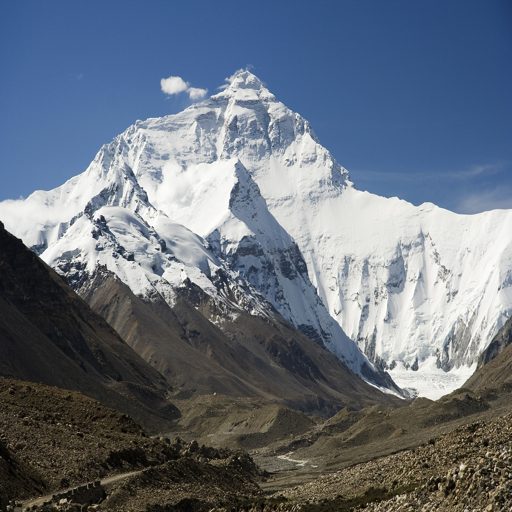

In [5]:
display(image.resize((512, 512)))

In [6]:
model.eval()
pred = model.infer_image(np.ascontiguousarray(image))

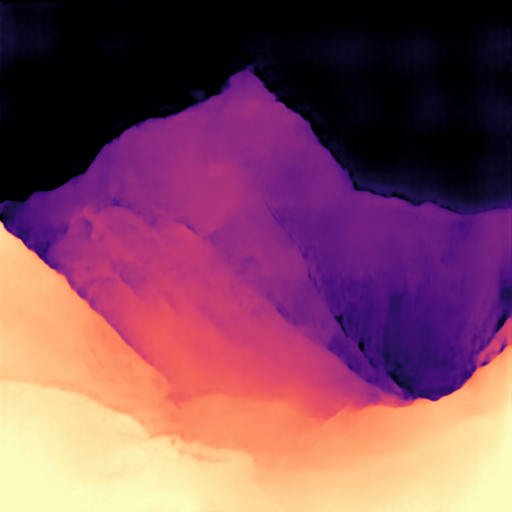

In [7]:
depth_img = Image.fromarray(colorize(pred))
display(depth_img.resize((512, 512)))

In [8]:
KITTI_DEPTH_SELECTION_PATH = Path("datasets/depth_selection")

In [9]:
class KittiDepthDatasetSelection(Dataset):
    def __init__(self):
        super().__init__()
        self.image_path = KITTI_DEPTH_SELECTION_PATH / "val_selection_cropped" / "image"
        self.ground_truth_path = (
            KITTI_DEPTH_SELECTION_PATH / "val_selection_cropped" / "groundtruth_depth"
        )
        self.image_paths, self.ground_truth_paths = self._prepare_data()

    def _get_image_params(self, image_path: Path) -> tuple[str, str, str, str]:
        params = image_path.stem.split("_")
        date = f"{params[0]}_{params[1]}_{params[2]}"
        record_index = params[4]
        index = params[-3]
        cam = params[-1]
        return date, record_index, index, cam

    def _prepare_data(self) -> tuple[list[Path], list[Path]]:
        image_paths = []
        ground_truth_paths = []
        for image_path in self.image_path.iterdir():
            date, record_index, index, cam = self._get_image_params(image_path)
            ground_truth_path = (
                self.ground_truth_path
                / f"{date}_drive_{record_index}_sync_groundtruth_depth_{index}_image_{cam}.png"
            )
            if not ground_truth_path.exists():
                print(f"Ground truth path {ground_truth_path} does not exist")
            image_paths.append(image_path)
            ground_truth_paths.append(ground_truth_path)
        return image_paths, ground_truth_paths

    def __len__(self) -> int:
        return len(self.image_paths)

    def __getitem__(self, idx: int) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
        image = Image.open(self.image_paths[idx])
        image = np.ascontiguousarray(image)
        ground_truth = Image.open(self.ground_truth_paths[idx])
        ground_truth = np.ascontiguousarray(ground_truth).astype(float) / 256.0
        valid_mask = (ground_truth > 0).astype(int)
        return image, ground_truth, valid_mask

In [10]:
selection_dataset = KittiDepthDatasetSelection()

In [11]:
def eval_depth(pred: torch.Tensor, target: torch.Tensor) -> dict[str, float]:
    assert pred.shape == target.shape

    thresh = torch.max((target / pred), (pred / target))

    d1 = torch.sum(thresh < 1.25).float() / len(thresh)
    d2 = torch.sum(thresh < 1.25 ** 2).float() / len(thresh)
    d3 = torch.sum(thresh < 1.25 ** 3).float() / len(thresh)

    diff = pred - target
    diff_log = torch.log(pred) - torch.log(target)

    abs_rel = torch.mean(torch.abs(diff) / target)
    sq_rel = torch.mean(torch.pow(diff, 2) / target)

    rmse = torch.sqrt(torch.mean(torch.pow(diff, 2)))
    rmse_log = torch.sqrt(torch.mean(torch.pow(diff_log , 2)))

    log10 = torch.mean(torch.abs(torch.log10(pred) - torch.log10(target)))
    silog = torch.sqrt(torch.pow(diff_log, 2).mean() - 0.5 * torch.pow(diff_log.mean(), 2))

    return {'d1': d1.item(), 'd2': d2.item(), 'd3': d3.item(), 'abs_rel': abs_rel.item(), 'sq_rel': sq_rel.item(), 
            'rmse': rmse.item(), 'rmse_log': rmse_log.item(), 'log10':log10.item(), 'silog':silog.item()}

In [15]:
idx = 67
img, true_depth, valid_mask = selection_dataset[idx]

with torch.no_grad():
    pred = model.infer_image(img)
    pred = torch.from_numpy(pred)

true_depth = torch.from_numpy(true_depth)
valid_mask = torch.from_numpy(valid_mask)
mask = (valid_mask == 1) & (true_depth >= min_depth) & (true_depth <= max_depth)

eval_depth(pred[mask], true_depth[mask])

{'d1': 0.8267835378646851,
 'd2': 0.9753225445747375,
 'd3': 0.9957190752029419,
 'abs_rel': 0.11359334285319307,
 'sq_rel': 0.6563198173256772,
 'rmse': 4.932692642532875,
 'rmse_log': 0.1768228758629811,
 'log10': 0.05392982949702992,
 'silog': 0.1671834504172881}

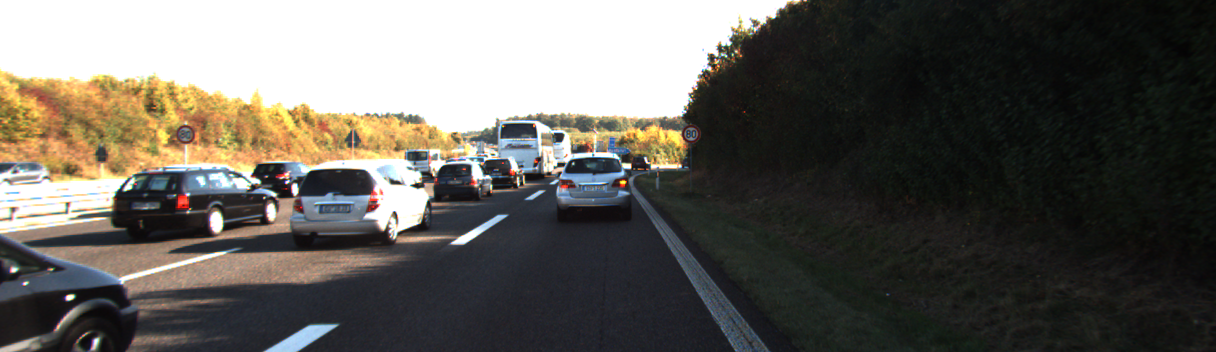

In [21]:
Image.fromarray(img.astype("uint8"))

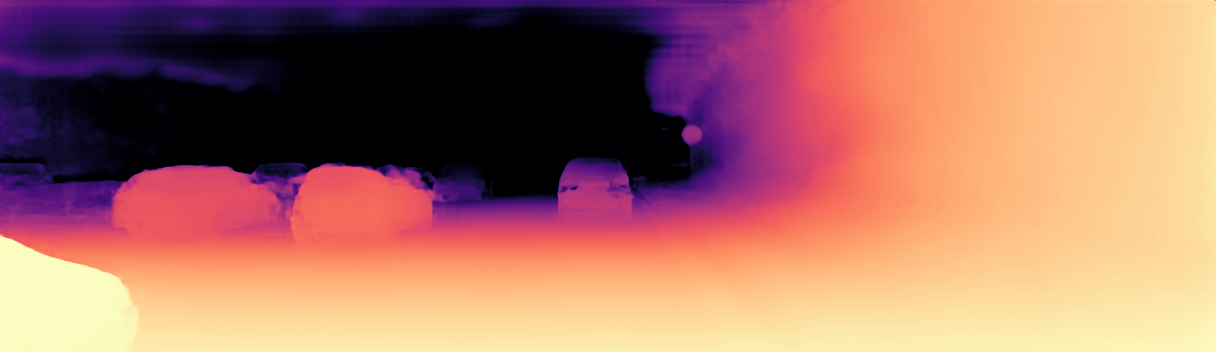

In [19]:
depth_colorized = colorize(pred)
Image.fromarray(depth_colorized.astype("uint8"))

In [ ]:
metrics = []

for img, true_depth, valid_mask in tqdm(
    selection_dataset, total=len(selection_dataset)
):
    with torch.no_grad():
        pred = model.infer_image(img)
        pred = torch.from_numpy(pred)

    true_depth = torch.from_numpy(true_depth)
    valid_mask = torch.from_numpy(valid_mask)
    mask = (valid_mask == 1) & (true_depth >= min_depth) & (true_depth <= max_depth)

    metrics.append(eval_depth(pred[mask], true_depth[mask]))

  0%|          | 0/1000 [00:00<?, ?it/s]

In [25]:
metrics = pd.DataFrame(metrics)
metrics.head()

,d1,d2,d3,abs_rel,sq_rel,rmse,rmse_log,log10,silog
0,0.719004,0.864053,0.981404,0.193377,1.153132,4.548936,0.259770,0.075200,0.257270
1,0.911849,0.972174,0.991553,0.093709,0.575737,4.492709,0.152094,0.041346,0.149364
2,0.843624,0.953322,0.987874,0.124571,0.946484,5.786920,0.192789,0.054335,0.192784
3,0.551037,0.909821,0.994805,0.173830,1.105792,5.610583,0.267162,0.086769,0.238959
4,0.850911,0.916280,0.954474,0.129390,1.329750,7.766768,0.254802,0.060649,0.254799


In [26]:
metrics.mean()

d1          0.789387
d2          0.925714
d3          0.980361
abs_rel     0.139472
sq_rel      0.974988
rmse        5.632479
rmse_log    0.224078
log10       0.063488
silog       0.215639
dtype: float64